In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset và xem một vài sample

In [2]:
mnist = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
(X_train_full, y_train_full), (X_test, y_test) = mnist

In [4]:
X_train_full = X_train_full/255.
X_test = X_test/255.

In [5]:
X_valid , X_train = X_train_full[:5000], X_train_full[5000:]
y_valid , y_train = y_train_full[:5000], y_train_full[5000:]

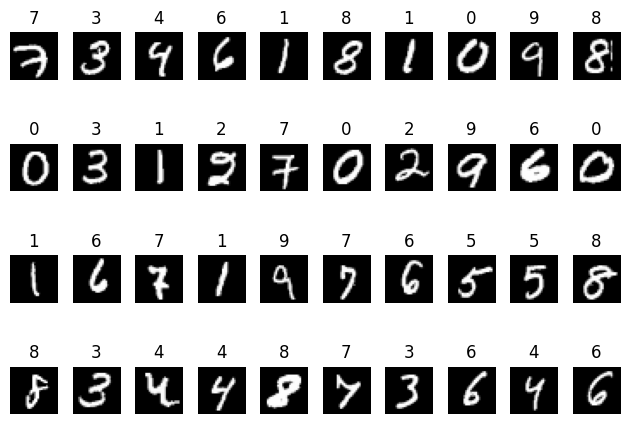

In [6]:
n_row = 4
n_col = 10

for row in range(n_row):
  for col in range(n_col):
    index = row * n_col + col
    plt.subplot(n_row, n_col, index + 1)
    plt.imshow(X_train[index], cmap = "gray")
    plt.axis('off')
    plt.title(y_train[index])

plt.tight_layout()
plt.show()

In [7]:
# thêm 1 chiều mới cho phù hợp với yêu cầu của lớp Conv
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Tăng cường dữ liệu

In [47]:
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0.1,0.1),
    tf.keras.layers.RandomZoom(0.1)
])

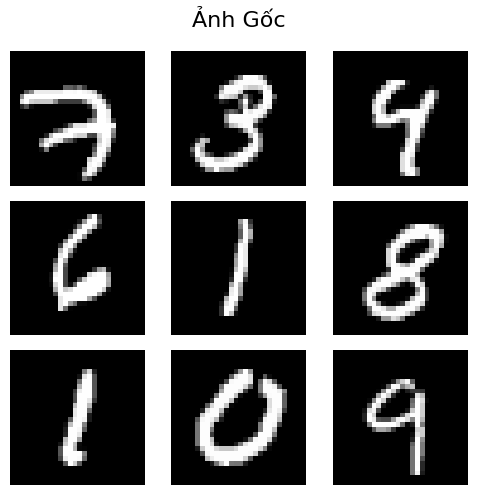

In [46]:
sample_images = X_train[:9]
plt.figure(figsize=(5, 5))
plt.suptitle("Ảnh Gốc", fontsize=16)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap ='gray') # Hiển thị ảnh gốc
    plt.axis("off")
plt.tight_layout()
plt.show()

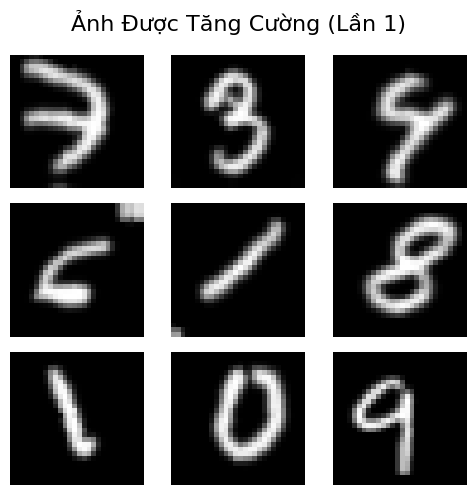

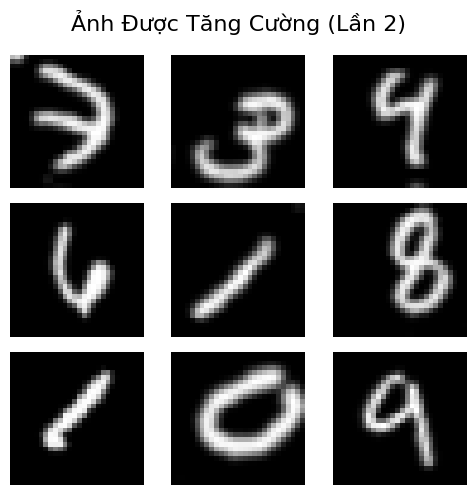

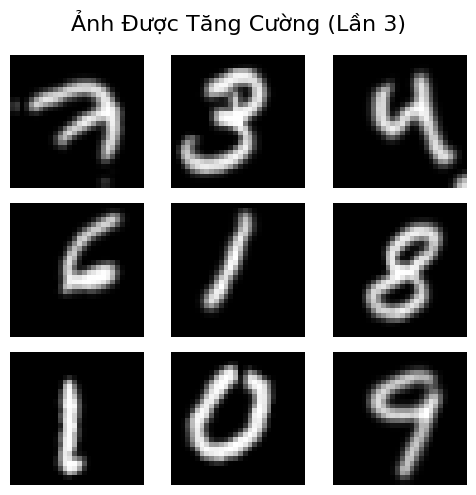

In [49]:
num_visualizations = 3
for viz_idx in range(num_visualizations):
    # Gọi data_augmentation_layers với training=True để áp dụng biến đổi
    # Các lớp này mong đợi một batch dữ liệu. sample_images đã là một batch.
    augmented_images = data_augmentation_layers(sample_images, training=True)

    plt.figure(figsize=(5, 5))
    plt.suptitle(f"Ảnh Được Tăng Cường (Lần {viz_idx + 1})", fontsize=16)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i],cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Tìm learning rate phù hợp

In [56]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor =  factor
    self.rates = []
    self.losses = []

  def on_batch_end(self, batch, logs = None):
    lr = self.model.optimizer.learning_rate.numpy() * self.factor
    self.model.optimizer.learning_rate = lr
    self.rates.append(lr)
    self.losses.append(logs['loss'])

  def plot(self):
    plt.plot(self.rates, self.losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(self.losses), min(self.rates), max(self.rates))
    plt.axis([min(self.rates), max(self.rates), 0, max(self.losses)])
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [57]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense

In [67]:
model = tf.keras.Sequential([
    data_augmentation_layers,
    # Block 1
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'), # Output shape will be (14, 14, 32)
    BatchNormalization(),
    Dropout(0.4),

    # Block 2
    Conv2D(64, kernel_size=3, activation='relu'), # Input (14, 14, 32), Output (12, 12, 64)
    BatchNormalization(),
    Conv2D(64, kernel_size=3, activation='relu'), # Output (10, 10, 64)
    BatchNormalization(),
    Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'), # Output (5, 5, 64)
    BatchNormalization(),
    Dropout(0.4),

    # Block 3
    Conv2D(128, kernel_size=4, activation='relu'), # Input (5, 5, 64), Output (2, 2, 128)
                                                # Nếu kernel_size=5 và padding='valid' (mặc định) thì output sẽ là (1,1,128)
                                                # Với kernel_size=4 và padding='valid', output là (2,2,128)
    BatchNormalization(),
    Flatten(), # Output (2*2*128 = 512)
    Dropout(0.4),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model_clone = tf.keras.models.clone_model(model)
model_clone.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (9, 28, 28, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (9, 26, 26, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (9, 26, 26, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (9, 24, 24, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (9, 24, 24, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (9, 12, 12, 32)        │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (9, 12, 12, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (9, 12, 12, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (9, 10, 10, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (9, 10, 10, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (9, 8, 8, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (9, 8, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (9, 4, 4, 64)          │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (9, 4, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (9, 4, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (9, 1, 1, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (9, 1, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (9, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (9, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (9, 10)                │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,242 (1.25 MB)

 Trainable params: 326,410 (1.25 MB)

 Non-trainable params: 832 (3.25 KB)

In [60]:
expon_lr = ExponentialLearningRate(factor = 1.0005)
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-6)
model_clone.compile(loss = "sparse_categorical_crossentropy",optimizer=optimizer, metrics = ["accuracy"])

In [61]:
model_clone.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid), callbacks = [expon_lr])

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.1002 - loss: 3.4288 - val_accuracy: 0.1704 - val_loss: 2.4655
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - accuracy: 0.1334 - loss: 3.1577 - val_accuracy: 0.4046 - val_loss: 1.7967
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.2240 - loss: 2.6548 - val_accuracy: 0.6766 - val_loss: 0.9941
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.4094 - loss: 1.8947 - val_accuracy: 0.8934 - val_loss: 0.3651
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.6569 - loss: 1.0590 - val_accuracy: 0.9556 - val_loss: 0.1527
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8393 - loss: 0.5123 - val_accuracy: 0.9718 - val_loss: 0.0938
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9154 - loss: 0.2765 - val_accuracy: 0.9810 - val_loss: 0.0619
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9391 -

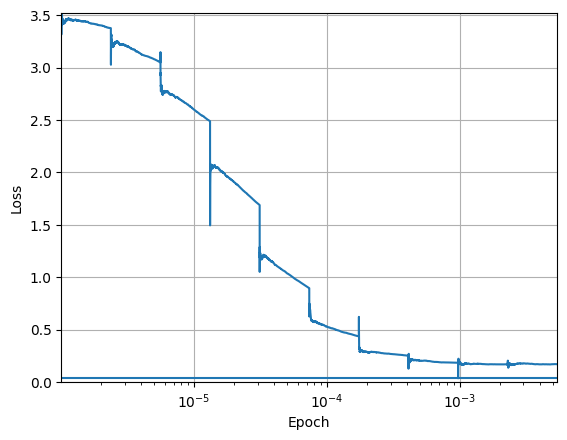

In [62]:
expon_lr.plot()

# Huấn luyện mô hình

In [68]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 5e-4)
model.compile(loss = "sparse_categorical_crossentropy",optimizer=optimizer, metrics = ["accuracy"])

In [69]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("bestmodel.keras", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [70]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_valid, y_valid), callbacks= [model_checkpoint, early_stopping])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.6634 - loss: 1.1018 - val_accuracy: 0.9778 - val_loss: 0.0737
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9364 - loss: 0.2146 - val_accuracy: 0.9788 - val_loss: 0.0663
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9526 - loss: 0.1562 - val_accuracy: 0.9820 - val_loss: 0.0536
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9606 - loss: 0.1276 - val_accuracy: 0.9858 - val_loss: 0.0401
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9668 - loss: 0.1094 - val_accuracy: 0.9858 - val_loss: 0.0431
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9697 - loss: 0.1029 - val_accuracy: 0.9894 - val_loss: 0.0319
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.9719 - loss: 0.0952 - val_accuracy: 0.9910 - val_loss: 0.0294
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 

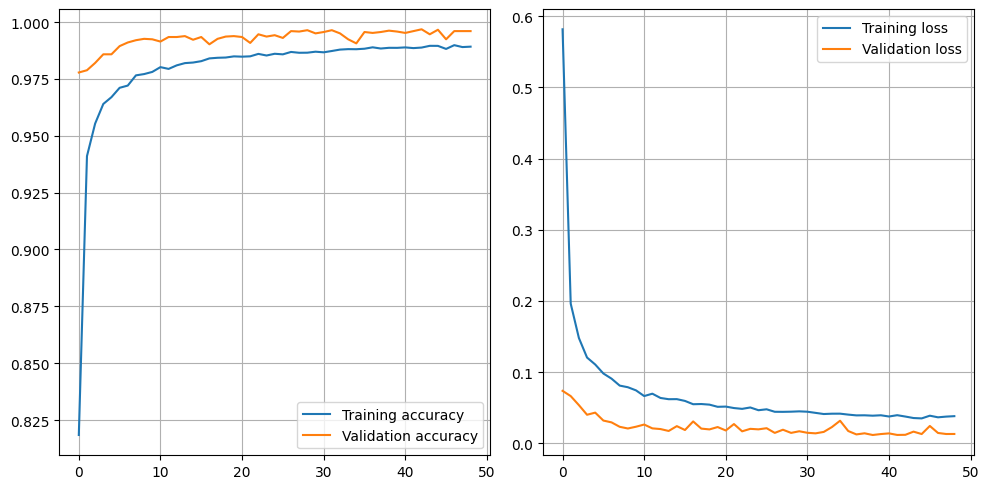

In [71]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label = "Validation accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label = "Training loss")
plt.plot(epochs, val_loss, label = "Validation loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()




In [74]:
model = tf.keras.models.load_model("bestmodel.keras")
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9936 - loss: 0.0214


[0.019818823784589767, 0.9934999942779541]